## <center> Mapping and clustering the top cities </center>
#### <center> Qiaozhou Xiong,qzxionghust@gmail.com</center>

## Introduction

   The world is experiencing the biggest urbanization in history. Over 65 millions people move to city every year, equivalent to adding 3 new Beijing. 
   
And now it's the first time the number of people living in urban area larger than that in rural. Cities make the modern society more productive and concentrated.
   The big city is a good window to know a country's culture, characteristics. We would explore the top cities in the world having the largest population or creating the most GDP. I will try to cluster the capital cities in the world into 5 types, based on several different indicators, such as size, people, GDP,  top common venue.
   
   Cities are playing the most important role in modern life. To know the basic information and underlying characteristics of a city will be beneficial to commercial activities. In this project, I will grab the basic information of the top cities in the world which contributes to the GDP most or carrying the most people from the website. Meanwhile, from Foursquare, I will grab the venues information of each city and explore the top 10 venues in each city.  Since we know the top cities would be a good example for most developing cities would be in the future. The top venues information is a kind of business opportunity for investment in developing cities. Another, cluttering the top cities would somehow reveal the similarity of cities, providing convenience for the management and operation in the city. 

## Method
### Data source

##### For the name of the top cities and population:  Wikipedia    
##### For the GDP data of the top cities: Wikipedia    
##### For the coordinate of the cities: Google API     
##### For the venues information of the top cities: Foursquare API    

### key techniques Involved:
#### A. grab tables information from web using beautifulSoup
#### B. regular expression for data cleaning
#### C. DataFrame manipulation, such as groupby, merge, concate
#### D. FourSquare API search
#### E. Data visualization
#### F. Clustering

## 1.Search the cities according to the GDP

In [1]:
# let's import the lib first
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib
print('libraries imported successfully')

libraries imported successfully


In [294]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_by_GDP'
page = urllib.request.urlopen(url)
# make soup
soup = BeautifulSoup(page,'html.parser')
tables = soup.select('table')

All the data initiated with tr, so we are going to findall 'tr' first and then extract the data

In [295]:
city = [] #creat list to contain the data
country = []
gdp = []
for index, row in enumerate(tables[0].findAll('tr')): # find each row
    if row.findAll('td'):           # the data start with td
        city.append(row.findAll('td')[0].contents[0].string) # the first column is city name.
        country.append(row.findAll('td')[1].findAll('a')[0].contents[0].string)# the second column is country name. 
        if row.findAll('td')[3].contents[0].string != None:
            gdp.append(row.findAll('td')[3].contents[0].string.replace('\n',''))# the fouth column is gdp
        else:
            gdp.append('')
# convert the data into dataframe
df = pd.DataFrame({'city':city, 'country':country, 'gdp':gdp})
df = df[df["gdp"]!=''] # delete those gpd is default

if we excute print(city, country, gdp), we could found some gpd is not in the right format, but followed with a year. Don't worry, we could use re method to replace it

In [261]:
import re
print('re library imported')

re library imported


Another type string is to be repaced is the coma, and then let's transform the data into float

In [296]:
df["gdp"] = df["gdp"].apply(lambda x: re.sub('(\s)*\([\d]*\)', '', x))
df["gdp"] = df["gdp"].apply(lambda x: re.sub(',', '', x))
df[["gdp"]] = df[["gdp"]].astype(float)

In [263]:
df.shape

(253, 3)

Now we have 253 cities' gdp data. Let's see the top 10 gdp cities

In [297]:
df.sort_values("gdp", inplace = True, ascending = False)
df.reset_index(drop = True, inplace = True)
df["gdp_ranking"] = df.index+1
df.head()

,city,country,gdp,gdp_ranking
0,Tokyo,Japan,1893.000,1
1,New York,United States,1717.712,2
2,Los Angeles,United States,1043.735,3
3,Seoul,South Korea,738.600,4
4,Paris,France,724.000,5


As we anticipated, all the top 10 gdp cities come from the most developed countries, USA, JP, UK, SK. Let's compare the cities categorized by country

In [94]:
# Before groupby let's define a function for the categorization
def f(x):
     return pd.DataFrame(dict(country = np.unique(x['country']),  #We extract the unique postcodes
                              cities = "%s" % ', '.join(x['city']), # merge the cities
                              gdp_sum = np.sum(x['gdp'])          #We add the gdp together belongs to the same country
                        )) 

In [97]:
df_country = df.groupby(["country"]).apply(f).reset_index(drop = True)

In [99]:
df_country.sort_values(["gdp_sum"], ascending = False, inplace = True)
df_country.head(10)

,country,cities,gdp_sum
44,United States,"New York, Los Angeles, Chicago, Dallas-Fort Wo...",14113.838
7,China,"Shanghai, Beijing, Guangzhou, Shenzhen, Chongq...",6268.800
23,Japan,"Tokyo, Osaka–Kobe, Nagoya, Fukuoka–Kitakyushu",3127.000
4,Brazil,"São Paulo, Rio de Janeiro, Brasília, Curitiba,...",1536.188
14,Germany,"Rhine-Ruhr, Berlin, Munich, Stuttgart, Nürnber...",1366.600
43,United Kingdom,"London, Manchester, Birmingham, Glasgow, Brist...",1274.800
12,France,"Paris, Marseille, Lyon, Lille, Toulouse, Borde...",1201.300
22,Italy,"Milan, Rome, Turin, Naples, Venice, Bologna, F...",1123.420
0,Australia,"Sydney, Melbourne, Brisbane, Perth, Adelaide",823.800
38,South Korea,Seoul,738.600


#### let's use seaborn to visualize the each country's contribution to the gdp created by the 253 cities

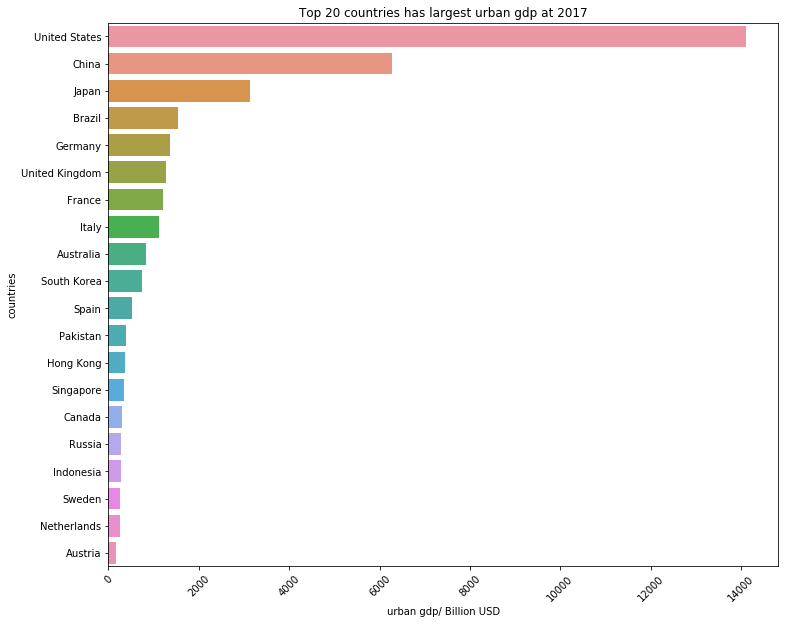

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = [12, 10])
ax = sns.barplot(ax = ax,  x = "gdp_sum", y = "country", data = df_country.head(20), orient = "h")
for item in ax.get_xticklabels():
    item.set_rotation(45)
ax.set_title('Top 20 countries has largest urban gdp at 2017')
ax.set_ylabel('countries')
ax.set_xlabel('urban gdp/ Billion USD')
plt.savefig('cities gdp by country.jpg')

As we can see, the USA was leading the word in urban gdp, almost the double of that of China.

## 2 Explore the population and totoal area of the cities in the world.

Still, we can grab the figures from Wikipedia, which is so informative.

In [300]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_proper_by_population'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
tables = soup.findAll('tbody')

#### Be careful! there is two tables in the webpage, so we need to select the table we are going to grab

In [301]:
## all the cities and numbers are after tr
city = []
pop = []
area = []
for row in tables[1].findAll('tr'):
    if row.findAll('td'):
        city.append(row.findAll('td')[1].contents[0].string)
        pop.append(row.findAll('td')[3].contents[0].string)
        area.append(row.findAll('td')[5].contents[0].string)
df_pop = pd.DataFrame({'city':city, 'pop':pop, 'area':area})

In [302]:
df_pop.shape

(87, 3)

##### we have 87 cities here, we are going to find more data on the web

In [303]:
# another wikipedia webpage about the population, we can also get some data here
url = r'https://en.wikipedia.org/wiki/List_of_cities_by_population_density'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'html.parser')
tables = soup.findAll('tbody')

In [304]:
city = []
pop = []
area = []
for row in tables[1].findAll('tr'):
    if row.findAll('td'):
        city.append(row.findAll('td')[0].contents[0].string)
        pop.append(row.findAll('td')[1].contents[0].string)
        area.append(row.findAll('td')[2].contents[0].string)
df_pop2 = pd.DataFrame({'city':city, 'pop':pop, 'area':area})

In [305]:
df_pop2.head()

,city,pop,area
0,Manila,"1,652,171",38.55
1,Ebeye,"15,000",0.362
2,Dhaka,"10,356,176",302.92
3,Pateros,"64,147",2.10
4,Cavite City,"319,104",10.89


In [306]:
df_pop.head()

,city,pop,area
0,Chongqing,"30,165,500","82,403"
1,Shanghai,"24,183,300","6,340.5"
2,Beijing,"21,707,000","16,411"
3,Istanbul,"15,029,231","5,196"
4,Karachi,"14,910,352","3,780"


##### let's merge the two data source about city population and area together.

In [307]:
df_popm = pd.concat([df_pop, df_pop2], axis = 0, join = 'outer')
df_popm.area = df_popm.area.apply(lambda x: re.sub(',', '',x))
df_popm[["area"]] = df_popm[["area"]].astype(float)
df_popm["pop"] = df_popm["pop"].apply(lambda x:re.sub(',', '', x))
df_popm[["pop"]] = df_popm[["pop"]].astype(float)

Let's make sure the data type are float for the population and area 

In [308]:
df_popm.dtypes

city     object
pop     float64
area    float64
dtype: object

Population density is another factor to describe a city, so let's add it to the dataframe

In [310]:
df_popm.sort_values(["pop"], ascending = False, inplace = True)
df_popm.reset_index(drop = True, inplace = True)
df_popm["popdst"] = df_popm["pop"]/df_popm["area"]
df_popm.head()

,city,pop,area,popdst
0,Chongqing,30165500.0,82403.0,366.072837
1,Shanghai,24183300.0,6340.5,3814.099834
2,Beijing,21707000.0,16411.0,1322.710377
3,Istanbul,15029231.0,5196.0,2892.461701
4,Karachi,14910352.0,3780.0,3944.537566


Let's add another colum as populatin ranking in the world

In [311]:
df_popm["pop_ranking"] = df_popm.index+1
df_popm.head()

,city,pop,area,popdst,pop_ranking
0,Chongqing,30165500.0,82403.0,366.072837,1
1,Shanghai,24183300.0,6340.5,3814.099834,2
2,Beijing,21707000.0,16411.0,1322.710377,3
3,Istanbul,15029231.0,5196.0,2892.461701,4
4,Karachi,14910352.0,3780.0,3944.537566,5


In [336]:
df_popm[df_popm["city"]=='Singapore']

,city,pop,area,popdst,pop_ranking
49,Singapore,5607000.0,602.75,9302.364164,50


Remind us the first data frame we get

In [312]:
df.head()

,city,country,gdp,gdp_ranking
0,Tokyo,Japan,1893.000,1
1,New York,United States,1717.712,2
2,Los Angeles,United States,1043.735,3
3,Seoul,South Korea,738.600,4
4,Paris,France,724.000,5


Finnaly, we merge them togther. merge method her, we merge df_popm on the right and, chose the index as the axis

In [379]:
df_final = pd.merge(df, df_popm, how = 'right', on = 'city' )
df_final["gdp_pp"] = 1e3*df_final["gdp"]/df_final["pop"]
df_final["gdp_pa"] = df_final["gdp"]/df_final["area"]
df_final.head()

,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,gdp_pa
0,Tokyo,Japan,1893.000,1.0,13515271.0,626.99,21555.799933,7,0.140064,3.019187
1,New York,United States,1717.712,2.0,8398748.0,786.30,10681.353173,30,0.204520,2.184550
2,Los Angeles,United States,1043.735,3.0,3976322.0,1213.85,3275.793549,68,0.262488,0.859855
3,Seoul,South Korea,738.600,4.0,9806000.0,605.25,16201.569599,22,0.075321,1.220322
4,Paris,France,724.000,5.0,2265886.0,105.40,21497.969639,95,0.319522,6.869070


Let's check whether the merging is sucessful

In [334]:
print(df[df.city == 'Paris'],'\n', df_popm[df_popm.city == 'Paris'])

    city country    gdp  gdp_ranking
4  Paris  France  724.0            5 
      city        pop   area        popdst  pop_ranking
94  Paris  2265886.0  105.4  21497.969639           95


Yes, it shows as what we got in separate DataFrames. Let's move on

#### Let's see the top 10 cities who has the highest gdp per person

Text(0.5, 0, 'gdp per person/million dollor')

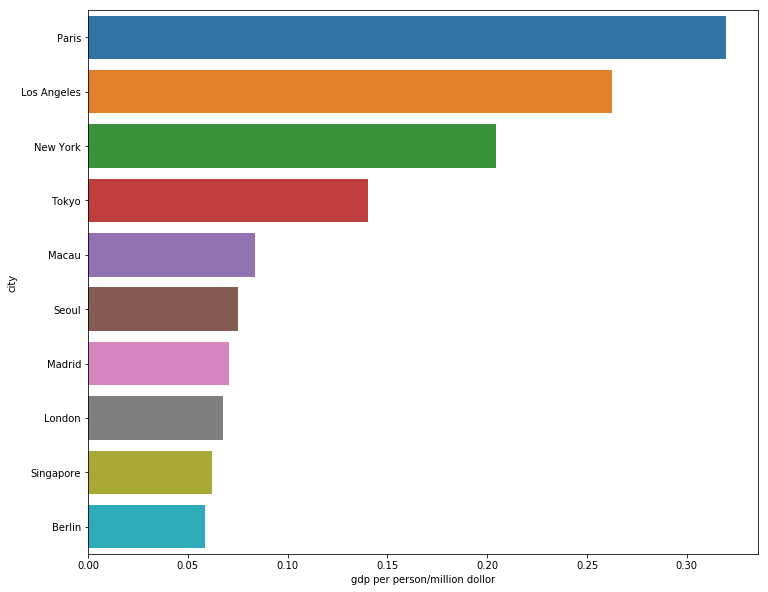

In [332]:
fig, ax = plt.subplots(figsize = [12, 10])
sns.barplot(x = 'gdp_pp', y = 'city', data = df_final.sort_values(["gdp_pp"], ascending = False).head(10), ax = ax)
ax.set_xlabel('gdp per person/million dollor')

We could find Paris created most gdp per person. We can say people at Paris, Los Angeles has the highest average income there

## 3 Explore  the top venues of the cities
#### we can use the FourSquare API to search the Top venues in the cities' data we had already.

In [287]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [381]:
df_final.dropna(axis = 0, inplace = True)

##### Let's grab the latitude and longitude first

In [ ]:
latitudes = []
longitudes = []
for (city, country) in zip(df_final.city, df_final.country):
    address = '{},{}'.format(city, country)
    print(address)
    geolocator = Nominatim(user_agent="ny_explorer")
    location = None
    ind = 0
    while(location is None):
        ind = 1+ind
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    latitudes.append(latitude)
    longitudes.append(longitude)

Let's add the longitude and latitude into the dataframe

In [384]:
df_final["longitude"] = longitudes
df_final["latitude"] = latitudes
df_final.head()

,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,gdp_pa,longitude,latitude
0,Tokyo,Japan,1893.000,1.0,13515271.0,626.99,21555.799933,7,0.140064,3.019187,139.759455,35.682839
1,New York,United States,1717.712,2.0,8398748.0,786.30,10681.353173,30,0.204520,2.184550,-74.006015,40.712728
2,Los Angeles,United States,1043.735,3.0,3976322.0,1213.85,3275.793549,68,0.262488,0.859855,-118.242767,34.053691
3,Seoul,South Korea,738.600,4.0,9806000.0,605.25,16201.569599,22,0.075321,1.220322,126.978291,37.566679
4,Paris,France,724.000,5.0,2265886.0,105.40,21497.969639,95,0.319522,6.869070,2.351499,48.856610


define FourSquare Credentials and version

In [385]:
CLIENT_ID = 'GPWKUVIRX0CM4QGME505R1CR21WVG21WN1VOI0WZSQPM0QIB' # your Foursquare ID
CLIENT_SECRET = 'IARW1LCM1GACKW1KJ5ZCBSDSIIIDD2M3DHFWJ0GZCVCJKXME' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [398]:
LIMIT = 500
def getNearbyVenues(names, latitudes, longitudes, radius = 1e4):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the get request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        #return only category information
        venues_list.append([(name,
                             v["venue"]["categories"][0]["name"]) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ["city",
                            "venue category"]
    return nearby_venues

            

Now, let's write the code to extract the venues categories for each city

In [399]:
city_venues = getNearbyVenues(names = df_final["city"],
                              latitudes = df_final["latitude"],
                              longitudes = df_final["longitude"])

Tokyo
New York
Los Angeles
Seoul
Paris
London
São Paulo
Shanghai
Beijing
Hong Kong
Singapore
Guangzhou
Shenzhen
Chongqing
Tianjin
Suzhou
Madrid
Moscow
Berlin
Rio de Janeiro
Chengdu
Wuhan
Jakarta
Nanjing
Changsha
Hangzhou
Ningbo
Foshan
Pune
Zhengzhou
Dongguan
Hefei
Harbin
Shenyang
Wenzhou
Xiamen
Saint Petersburg
Macau
Zhongshan
Shantou
Bandung


#### Awesome, we have finished data collection from FourSquare API.Next I am going to group them by city

In [400]:
#always try to have a look of the data before excute new data
city_venues.head(5)

,city,venue category
0,Tokyo,Hotel
1,Tokyo,Hotel
2,Tokyo,Bookstore
3,Tokyo,Garden
4,Tokyo,Japanese Curry Restaurant


Let's check how many venues were collect for each city

In [401]:
city_venues.groupby(["city"]).count()

,venue category
city,
Bandung,100
Beijing,100
Berlin,100
Changsha,43
Chengdu,100
Chongqing,74
Dongguan,58
Foshan,50
Guangzhou,100


##### It looks ok for most cities but some city does not have enough data

#### let's find out how many categories can be curated from all the returned venues

In [403]:
print('There are {} unique categories'.format(len(city_venues["venue category"].unique())))

There are 330 unique categories


In [404]:
# one hot encoding
city_venue_onehot = pd.get_dummies(city_venues[["venue category"]], prefix = "", prefix_sep = "")
# adding city name to the back of the dataframe
city_venue_onehot["city"] = city_venues["city"]
# move city to the first column
fixed_col = [city_venue_onehot.columns[-1]]+list(city_venue_onehot.columns[:-1])
city_venue_onehot = city_venue_onehot[fixed_col]

city_venue_onehot.head()

,city,Acai House,Adult Boutique,African Restaurant,Airport,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Wine Shop,Winery,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tokyo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group by city and taking the mean of the frequency of the occurence of each category

In [407]:
city_venue_grouped = city_venue_onehot.groupby(["city"]).mean().reset_index()
city_venue_grouped.head()

,city,Acai House,Adult Boutique,African Restaurant,Airport,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Wine Shop,Winery,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Zoo Exhibit
0,Bandung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
1,Beijing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.01,0.0,0.0,0.0,0.03,0.01,0.0,0.00
2,Berlin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.02,...,0.01,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
3,Changsha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00
4,Chengdu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.01


#### Let's create a new dataframe to contain the top 10 venues for each city

###### First, let's write a function to return the top venuse

In [423]:
def return_most_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [476]:
# return top 10 venues
num_top_venues = 10
columns = ["city"]
columns.extend(["The 1st common venue", "The 2nd common venue", "The 3rd common venue"])
columns.extend(['The {}th common venue'.format(element) for element in range(4,11)])
#create a new Dataframe
city_venues_sorted = pd.DataFrame(columns = columns)
city_venues_sorted["city"] = city_venue_grouped["city"]
for ind in np.arange(city_venue_grouped.shape[0]):
    city_venues_sorted.iloc[ind,1:] = return_most_venues(city_venue_grouped.iloc[ind,:], num_top_venues)
city_venues_sorted.head()

,city,The 1st common venue,The 2nd common venue,The 3rd common venue,The 4th common venue,The 5th common venue,The 6th common venue,The 7th common venue,The 8th common venue,The 9th common venue,The 10th common venue
0,Bandung,Hotel,Bakery,Coffee Shop,Café,Snack Place,Sundanese Restaurant,Indonesian Restaurant,Multiplex,Sushi Restaurant,Shopping Mall
1,Beijing,Historic Site,Hotel,Park,Peking Duck Restaurant,Café,Dumpling Restaurant,Chinese Restaurant,Coffee Shop,Yunnan Restaurant,Beijing Restaurant
2,Berlin,Coffee Shop,Park,Bookstore,Concert Hall,Sandwich Place,Ice Cream Shop,Vegetarian / Vegan Restaurant,Wine Bar,Science Museum,Bakery
3,Changsha,Coffee Shop,Hotel,Shopping Mall,Park,Chinese Restaurant,Fast Food Restaurant,Historic Site,Multiplex,Café,Outdoor Sculpture
4,Chengdu,Hotel,Shopping Mall,Coffee Shop,Fast Food Restaurant,Hostel,Furniture / Home Store,Café,Noodle House,Bar,History Museum


#### Ok now, we have the most common categories in each city. The most common venues can be kind of representative of the culture. Let's merge it with our previous dataframe

In [477]:
# let's encode the most cmmon venue categories first
venues_onehot = pd.get_dummies(city_venues_sorted[["The 1st common venue"]],prefix = "", prefix_sep = "")
venues_categories = city_venues_sorted["The 1st common venue"].unique()
venues_onehot["city"] = city_venues_sorted["city"]
fixed_col = [venues_onehot.columns[-1]]+list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_col]
venues_onehot.head(10)

,city,Boat or Ferry,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
0,Bandung,0,0,0,1,0,0,0,0,0,0,0
1,Beijing,0,0,1,0,0,0,0,0,0,0,0
2,Berlin,0,1,0,0,0,0,0,0,0,0,0
3,Changsha,0,1,0,0,0,0,0,0,0,0,0
4,Chengdu,0,0,0,1,0,0,0,0,0,0,0
5,Chongqing,0,0,0,1,0,0,0,0,0,0,0
6,Dongguan,0,1,0,0,0,0,0,0,0,0,0
7,Foshan,0,1,0,0,0,0,0,0,0,0,0
8,Guangzhou,0,0,0,1,0,0,0,0,0,0,0
9,Hangzhou,0,1,0,0,0,0,0,0,0,0,0


In [478]:
venues_onehot[venues_onehot['Historic Site'] == 1]

,city,Boat or Ferry,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
1,Beijing,0,0,1,0,0,0,0,0,0,0,0


#### it's confirmed that Beijing is a historical city

In [479]:
df_city = pd.merge(df_final, venues_onehot, how = 'right', on = "city")
df_city.head()

,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,gdp_pa,...,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
0,Tokyo,Japan,1893.000,1.0,13515271.0,626.99,21555.799933,7,0.140064,3.019187,...,0,0,1,0,0,0,0,0,0,0
1,New York,United States,1717.712,2.0,8398748.0,786.30,10681.353173,30,0.204520,2.184550,...,0,0,0,0,1,0,0,0,0,0
2,Los Angeles,United States,1043.735,3.0,3976322.0,1213.85,3275.793549,68,0.262488,0.859855,...,1,0,0,0,0,0,0,0,0,0
3,Seoul,South Korea,738.600,4.0,9806000.0,605.25,16201.569599,22,0.075321,1.220322,...,0,0,1,0,0,0,0,0,0,0
4,Paris,France,724.000,5.0,2265886.0,105.40,21497.969639,95,0.319522,6.869070,...,0,0,0,0,0,0,1,0,0,0


## 4.find the similarity and disimilarity of these cities

#### let's see the most common venues in each city first

In [574]:
venue = []
venue = venues_onehot.iloc[:,1:].sum(axis=0)
venue = pd.DataFrame(venue)
venue.columns = ['No']
venue = venue.reset_index()

##### let's make a bar plot to show the most common venues in the largest cities

Text(0, 0.5, 'category')

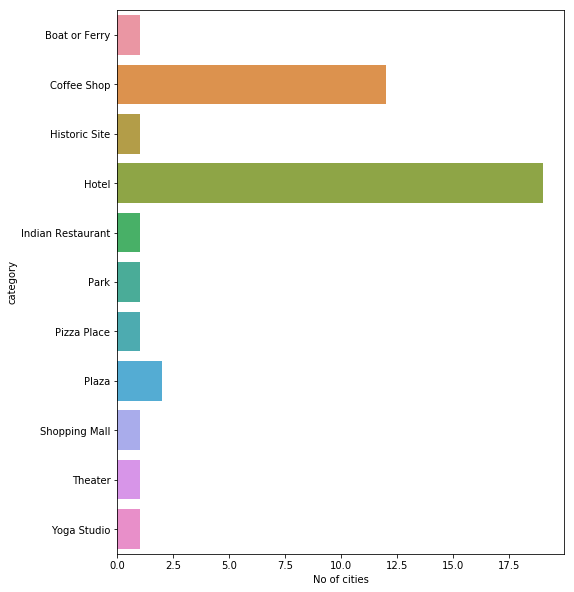

In [577]:
fig, ax = plt.subplots(figsize = [8,10])
ax = sns.barplot(ax = ax, x = 'No', y = 'category', data = venue)
ax.set_xlabel('No of cities')
ax.set_ylabel('category')

##### Let's explore further which cities hotel is most common venue

In [578]:
df_city[df_city["Hotel"]==1]

,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,gdp_pa,...,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
0,Tokyo,Japan,1893.0,1.0,13515271.0,626.99,21555.799933,7,0.140064,3.019187,...,0,0,1,0,0,0,0,0,0,0
3,Seoul,South Korea,738.6,4.0,9806000.0,605.25,16201.569599,22,0.075321,1.220322,...,0,0,1,0,0,0,0,0,0,0
5,London,United Kingdom,595.7,10.0,8825001.0,1572.00,5613.868321,27,0.067501,0.378944,...,0,0,1,0,0,0,0,0,0,0
7,Shanghai,China,469.0,15.0,24183300.0,6340.50,3814.099834,2,0.019394,0.073969,...,0,0,1,0,0,0,0,0,0,0
9,Hong Kong,Hong Kong,364.8,21.0,7298600.0,1104.43,6608.476771,37,0.049982,0.330306,...,0,0,1,0,0,0,0,0,0,0
10,Singapore,Singapore,349.5,24.0,5607000.0,602.75,9302.364164,50,0.062333,0.579842,...,0,0,1,0,0,0,0,0,0,0
11,Guangzhou,China,341.0,27.0,13081000.0,7434.00,1759.617971,9,0.026068,0.045870,...,0,0,1,0,0,0,0,0,0,0
12,Shenzhen,China,338.0,28.0,12528300.0,1992.00,6289.307229,10,0.026979,0.169679,...,0,0,1,0,0,0,0,0,0,0
13,Chongqing,China,288.8,31.0,30165500.0,82403.00,366.072837,1,0.009574,0.003505,...,0,0,1,0,0,0,0,0,0,0
15,Suzhou,China,256.5,36.0,5983000.0,8488.00,704.877474,48,0.042871,0.030219,...,0,0,1,0,0,0,0,0,0,0


#### interestingly, all of these cities belongs to Asia except for London. That might because the cultrue difffernce of the western and Eastern.

How about the coffe shope

In [580]:
df_city[df_city["Coffee Shop"]==1]

,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,gdp_pa,...,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
2,Los Angeles,United States,1043.735,3.0,3976322.0,1213.85,3275.793549,68,0.262488,0.859855,...,1,0,0,0,0,0,0,0,0,0
14,Tianjin,China,275.400,32.0,11249000.0,11920.00,943.708054,16,0.024482,0.023104,...,1,0,0,0,0,0,0,0,0,0
18,Berlin,Germany,215.200,42.0,3671000.0,891.75,4116.624615,72,0.058622,0.241323,...,1,0,0,0,0,0,0,0,0,0
19,Rio de Janeiro,Brazil,209.366,43.0,6520000.0,751.44,8676.674119,46,0.032111,0.278620,...,1,0,0,0,0,0,0,0,0,0
21,Wuhan,China,198.600,46.0,8035000.0,8494.00,945.961855,32,0.024717,0.023381,...,1,0,0,0,0,0,0,0,0,0
22,Jakarta,Indonesia,186.000,49.0,10624000.0,661.50,16060.468632,19,0.017508,0.281179,...,1,0,0,0,0,0,0,0,0,0
24,Changsha,China,156.000,63.0,7044118.0,11819.00,595.999492,40,0.022146,0.013199,...,1,0,0,0,0,0,0,0,0,0
25,Hangzhou,China,150.800,66.0,7035000.0,850.83,8268.396742,41,0.021436,0.177239,...,1,0,0,0,0,0,0,0,0,0
27,Foshan,China,141.400,73.0,9279000.0,3797.00,2443.771398,23,0.015239,0.037240,...,1,0,0,0,0,0,0,0,0,0
30,Dongguan,China,112.300,92.0,10615000.0,2460.00,4315.040650,20,0.010579,0.045650,...,1,0,0,0,0,0,0,0,0,0


### It looks coffee shop is more univerally spread in cities all around the world

### Next, let's add the top 10 venues together to have a look

In [617]:
categories = city_venues_sorted.columns.values.tolist()[1:3]

Let's processing each column first and concate them together

In [633]:
# let's encode the most cmmon venue categories first
venues_onehots = pd.DataFrame()
for category in categories:
    print(category)
    venues_onehot = pd.get_dummies(city_venues_sorted[[category]],prefix = "", prefix_sep = "")
    venues_onehot["city"] = city_venues_sorted["city"]
    fixed_col = [venues_onehot.columns[-1]]+list(venues_onehot.columns[:-1])
    venues_onehot = venues_onehot[fixed_col]
    venues_onehot = venues_onehot.set_index(["city"])
    venues = venues_onehot.iloc[:,1:].sum(axis = 0)
    venue = pd.DataFrame(venues)
    venue.columns = ['No']
    venue = venue.reset_index()
    venues_onehots = pd.concat([venues_onehots, venue], axis = 0, join = 'outer')
venues_onehots.head()

The 1st common venue
The 2nd common venue
The 3rd common venue
The 4th common venue
The 5th common venue
The 6th common venue
The 7th common venue
The 8th common venue
The 9th common venue
The 10th common venue


,index,No
0,Coffee Shop,12
1,Historic Site,1
2,Hotel,19
3,Indian Restaurant,1
4,Park,1


Update the index and columns' name

In [638]:
venues_onehots.columns = ["category", "No"]
venues_onehots.reset_index(drop = True, inplace = True)

In [642]:
top_com_venues = venues_onehots.groupby(["category"]).sum()
top_com_venues.head()

,No
category,
Art Gallery,1
Art Museum,2
BBQ Joint,3
Bakery,4
Bar,7


Let's draw th bar figure again,  we only draw the top 10 most common venues

In [647]:
top_com_venues.sort_values(by = ["No"], inplace = True, ascending = False)
top_com_venues.reset_index(inplace = True)

Text(0.5, 1.0, 'Top 10 most common venues in the top cities')

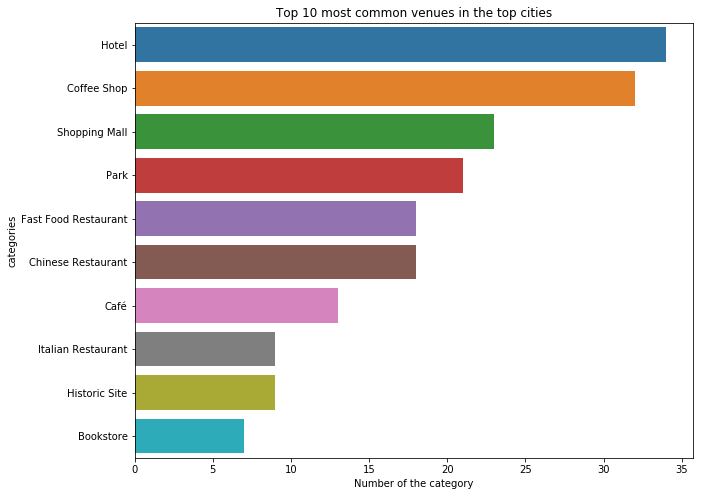

In [649]:
fig, ax = plt.subplots(figsize = [10, 8])
ax = sns.barplot(ax = ax, x = "No", y = "category", data = top_com_venues.head(10))
ax.set_xlabel('Number of the category')
ax.set_ylabel('categories')
ax.set_title('Top 10 most common venues in the top cities')

### We can still find the top 3 most common venues are Hotel, coffee shop, Shopping mall. Almost for each city, Hotel belongs to the top 10 most common venues. We could assume Hotel will continue to be growing in those developing cities. It's might be a business opportunity if there is still few such ten top venues in the city

## 5. Cluster the cities

### We can try select GDP, Population, area, and Venues to categorize these cities

In [449]:
columns = ["gdp", "pop", "area"]
columns.extend(venues_categories.tolist())
df_clustering = df_city[columns]

In [463]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
# preprocessing for standarization
X_train = preprocessing.scale(df_clustering)
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X_train)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
df_city["Cluster Labels"] =  kmeans.labels_
df_city.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


,Cluster Labels,city,country,gdp,gdp_ranking,pop,area,popdst,pop_ranking,gdp_pp,...,Coffee Shop,Historic Site,Hotel,Indian Restaurant,Park,Pizza Place,Plaza,Shopping Mall,Theater,Yoga Studio
0,2,Tokyo,Japan,1893.000,1.0,13515271.0,626.99,21555.799933,7,0.140064,...,0,0,1,0,0,0,0,0,0,0
1,4,New York,United States,1717.712,2.0,8398748.0,786.30,10681.353173,30,0.204520,...,0,0,0,0,1,0,0,0,0,0
2,1,Los Angeles,United States,1043.735,3.0,3976322.0,1213.85,3275.793549,68,0.262488,...,1,0,0,0,0,0,0,0,0,0
3,2,Seoul,South Korea,738.600,4.0,9806000.0,605.25,16201.569599,22,0.075321,...,0,0,1,0,0,0,0,0,0,0
4,1,Paris,France,724.000,5.0,2265886.0,105.40,21497.969639,95,0.319522,...,0,0,0,0,0,0,1,0,0,0


### Last, let's visualize them on the map

In [464]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start=2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, cluster, gdp_ranking, people_ranking in zip(df_city['latitude'], df_city['longitude'], df_city['city'], df_city['Cluster Labels'],df_city['gdp_ranking'], df_city['pop_ranking']):
    label = folium.Popup(str(city) +', Cluster '+str(cluster)+', GDP ranking '+str(gdp_ranking)+', peopulation ranking '+str(people_ranking), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can find New York, Beijing, Chongqing are quite special cities. Since the cities in China tend to have large amount of population, the gdp is also quite higher.

### The clustering in somehow can show the similarity of these cities. For international company, experience could be shared with these cities belong to the same cluster.

#### Thanks for reading this lab. This lab was created by Qiaozhou Xiong, for the Capstone project in the Data science course